In [1]:
import tensorflow as tf
import numpy as np

print("TensorFlow Version:", tf.__version__)
print("NumPy Version:", np.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow Version: 2.10.0
NumPy Version: 1.23.5
Built with CUDA: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import tensorflow as tf
print(tf.__version__)


2.10.0


In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import get_file

In [4]:
path_to_file = get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt') 
text = open(path_to_file, 'rb').read().decode(encoding='utf-8') 

print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
vocab_size = 10000
seq_length = 100

vectorizer = TextVectorization(max_tokens = vocab_size, output_mode = 'int')
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)
vectorizer.adapt(text_ds)

vectorized_text = vectorizer([text])[0]
print("Vectorized text shape: ", vectorized_text.shape)
print("First 10 vectorized tokens: ", vectorized_text.numpy()[:10])

Vectorized text shape:  (202646,)
First 10 vectorized tokens:  [ 89 270 138  36 982 144 673 125  16 106]


In [6]:
def create_sequences(text, seq_length):
    input_seqs = []
    target_seqs = []
    for i in range(len(text)-seq_length):
        input_seq = text[i:i + seq_length]
        target_seq = text[i+1:i+seq_length+1]
        input_seqs.append(input_seq)
        target_seqs.append(target_seq)
    return np.array(input_seqs), np.array(target_seqs)

x, y = create_sequences(vectorized_text.numpy(), seq_length)

print("Number of sequences generated: ", len(x))
print("Sample input sequence:", x[0] if len(x) > 0 else "No sequences generated") 

assert x.size > 0, "Input data X is empty" 
assert y.size > 0, "Target data Y is empty" 
x = tf.convert_to_tensor(x) 
y = tf.convert_to_tensor(y) 
print("Shape of X:", x.shape) 
print("Shape of Y:", y.shape)

Number of sequences generated:  202546
Sample input sequence: [  89  270  138   36  982  144  673  125   16  106   34  106  106   89
  270    7   41   34 1286  344    4  200   64    4 3690   34 1286 1286
   89  270   89    7   93 1187  225   12 2442  592    4    2  307   34
   36 2655   36 2655   89  270   72   79  506   27    3   56   24 1390
   57   40  161 2328  644    9 4980   34   32   54 2863  885   72   17
   18  163  146  146  165  270   74  218   46  595   89  270   36   41
 6739  172  595    2 1780   46   29 1323 5151   47   58 4151   79   39
   60   58]
Shape of X: (202546, 100)
Shape of Y: (202546, 100)


In [7]:
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerModel(Model):  
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)  
        output = self.dense(x)
        return output

In [8]:
embed_dim = 256
num_heads = 4
ff_dim = 512
num_layers = 4

model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)
_ = model(tf.random.uniform((1, seq_length), maxval = vocab_size, dtype = tf.int32))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.summary()

Model: "transformer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2560000   
                                                                 
 transformer_block (Transfor  multiple                 1315840   
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  multiple                 1315840   
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  multiple                 1315840   
 ormerBlock)                                                     
                                                                 
 transformer_block_3 (Transf  multiple                 1315840   
 ormerBlock)                                     

Epoch 1/20
6330/6330 [==============================] - 654s 102ms/step - loss: 11.9941
Epoch 2/20
6330/6330 [==============================] - 643s 102ms/step - loss: 12.0581
Epoch 3/20
6330/6330 [==============================] - 651s 103ms/step - loss: 11.9302
Epoch 4/20
6330/6330 [==============================] - 641s 101ms/step - loss: 11.2263
Epoch 5/20
6330/6330 [==============================] - 636s 100ms/step - loss: 10.8412
Epoch 6/20
6330/6330 [==============================] - 646s 102ms/step - loss: 10.6133
Epoch 7/20
6330/6330 [==============================] - 642s 101ms/step - loss: 10.4996
Epoch 8/20
6330/6330 [==============================] - 648s 102ms/step - loss: 10.5063
Epoch 9/20
6330/6330 [==============================] - 650s 103ms/step - loss: 10.6534


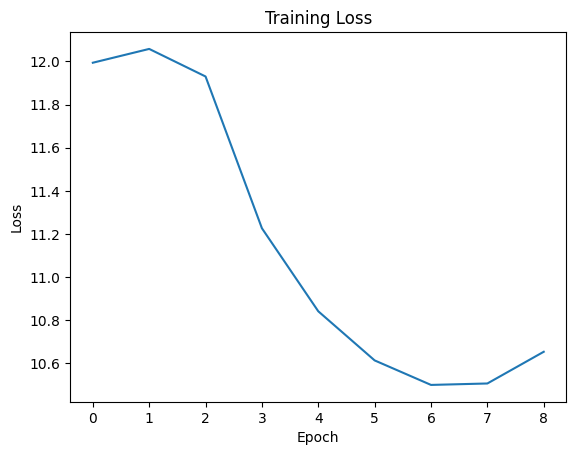

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

history = model.fit(x, y, epochs=20, batch_size=32, callbacks=[early_stopping])

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [10]:
def generate_text(seed_text, next_words, max_seq_length):
    for _ in range(next_words):
        # Convert seed text to tokens
        tokenized_input = vectorizer([seed_text])[:, -max_seq_length:]
        
        # Predict next token
        predicted_logits = model(tokenized_input)
        predicted_token = tf.argmax(predicted_logits[:, -1, :], axis=-1).numpy()[0]
        
        # Convert token back to word
        next_word = vectorizer.get_vocabulary()[predicted_token]
        
        # Add predicted word to seed text
        seed_text += ' ' + next_word
    
    return seed_text


In [11]:
seed_text = "Shall I compare thee to a summer's day"
generated_text = generate_text(seed_text, next_words=50, max_seq_length=seq_length)
print(generated_text)


Shall I compare thee to a summer's day or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or or


In [16]:
import numpy as np

def generate_text_with_temperature(seed_text, next_words, max_seq_length, temperature=1.2):
    for _ in range(next_words):
        tokenized_input = vectorizer([seed_text])[:, -max_seq_length:]
        predicted_logits = model(tokenized_input)
        
        # Apply temperature
        logits = predicted_logits[:, -1, :] / temperature
        probs = tf.nn.softmax(logits).numpy()[0]
        
        # Sample from the distribution
        predicted_token = np.random.choice(len(probs), p=probs)
        next_word = vectorizer.get_vocabulary()[predicted_token]
        
        seed_text += ' ' + next_word
    
    return seed_text


In [17]:
seed_text = "To be or not to be"
generated_text = generate_text_with_temperature(seed_text, next_words=50, max_seq_length=seq_length, temperature=1.0)
print(generated_text)


To be or not to be fish rubies immediate fount despite betrothd mammet leaden butt measles released stumble amiss scholar rugheaded leash apollos piercing swearing melancholy tickled notion soul bloody disorderd topbranch windy message cloister stale strip rite distraught beget gazed recure craft newborn formerly months lineal parents beauteous nearlegged rightly securely penny dust postern bids


In [18]:
def top_p_sampling(logits, p=0.9):
    sorted_indices = np.argsort(logits)[::-1]
    sorted_probs = tf.nn.softmax(logits[sorted_indices]).numpy()
    cumulative_probs = np.cumsum(sorted_probs)

    # Keep only tokens with cumulative probability <= p
    sorted_indices = sorted_indices[cumulative_probs <= p]
    sorted_probs = sorted_probs[:len(sorted_indices)]

    predicted_token = np.random.choice(sorted_indices, p=sorted_probs / sum(sorted_probs))
    return predicted_token
def generate_text_with_top_p(seed_text, next_words, max_seq_length, p=0.9):
    for _ in range(next_words):
        tokenized_input = vectorizer([seed_text])[:, -max_seq_length:]
        predicted_logits = model(tokenized_input)[:, -1, :]
        predicted_token = top_p_sampling(predicted_logits[0].numpy(), p)
        next_word = vectorizer.get_vocabulary()[predicted_token]
        seed_text += ' ' + next_word
    return seed_text
generated_text = generate_text_with_top_p(seed_text, next_words=50, max_seq_length=seq_length, p=0.9)
print(generated_text)


To be or not to be shipboard nursed wheres reputed expedient give montgomery beauty antigonus ally sneaping promise leagues fool taught ware enrich promise remembrances steads shineth regreet heralds bishop rayed relate burden scatters scratch prefers deed mose fairest bountiful ginger blessed pure reside slandertybalt meantime cheated shortst undescried swineherds gains strangely maythat as entreaties guard


In [20]:
import numpy as np
import tensorflow as tf

def sample_with_top_p_and_temp(predictions, top_p=0.9, temperature=1.0):
    # Apply temperature
    logits = predictions / temperature
    
    # Get sorted token probabilities
    sorted_indices = np.argsort(logits)[::-1]
    sorted_logits = logits[sorted_indices]
    sorted_probs = tf.nn.softmax(sorted_logits).numpy()

    # Get cumulative probability
    cumulative_probs = np.cumsum(sorted_probs)

    # Keep only tokens whose cumulative probability <= top_p
    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_probs[sorted_indices_to_remove] = 0
    sorted_probs /= np.sum(sorted_probs)

    # Sample from the filtered distribution
    next_token = np.random.choice(sorted_indices, p=sorted_probs)

    return next_token

def generate_text_with_top_p_and_temp(seed_text, next_words=50, max_seq_length=100, top_p=0.9, temperature=1.0):
    for _ in range(next_words):
        # Preprocess input
        tokenized_input = vectorizer([seed_text])[:, -max_seq_length:]
        
        # Predict next token logits
        predictions = model(tokenized_input, training=False)[0, -1, :].numpy()
        
        # Sample next token using Top-P + Temperature
        next_token = sample_with_top_p_and_temp(predictions, top_p, temperature)
        
        # Convert token back to word
        next_word = vectorizer.get_vocabulary()[next_token]
        
        # Add the word to seed text
        seed_text += " " + next_word
    
    return seed_text

# Example usage:
seed_text = "To be or not to be"
generated_text = generate_text_with_top_p_and_temp(seed_text, next_words=50, top_p=0.9, temperature=0.8)
print(generated_text)


To be or not to be hateful aqua wildest intended wondering starkly ready metre statues tinderlike amend wedlock commission do indifferent sell lately preoccupied step mild rank mum percussion greek apology victors cunning finds sprang drowning aim nimblepiniond widowhood subsisting sheeps experience shipping sheangel wrong pots majestical sops steps mamillius wipe brooch curtain stealing paind milder
